# SEQP Personalized Signal Generator
This is a Jupyter notebook designed to create a personalized version of the SEQP test signal. 

1) Type in your callsign and grid square below.
2) Click "Run All Cells" in the "Run" menu above.
3) Wait for all cells to run.
4) Open the file browser on the left and download the .wav and .csv files to your local machine.
5) You can play the audio on your radio with a standard audio input; or, if you have an arbitrary waveform generator, upload the .csv. (Don't open it in Excel first!)

### Changes implemented in Version 2, upon request by WA5FRF

   - [x] Reduce the number of CW iterations of the grid square in the preamble to 1. E.g., use only “DE WA5FRF EL09NN”. This is to shorten the overall message length. (The thrice repetition in TEST TEST TEST DE CALL CALL CALL is kept in order to facilitate use with RBN.)
   - [x]  Eliminate both instances of the fastest 100 Hz/ms chirps. These presently comprise the first group of 5 chirps and the last string of concatenated up/down chirps. There is now ample evidence of problems with the fast chirp rate in radios with both analog and digital audio processing. The fast chirp evidently gets distorted by the multi-pole audio filters used to shape the radio’s passband. In both my original hand-processed data and the automated processing done by the students the 100 Hz/ms chirp rate gave very different results than the slower 50, 25, and 10 Hz/ms rates. Alex Papadopoulos showed me graphs of TDOA and Layer Height vs. time for the individual and average sweep rates. The 50, 25, and 10 Hz/ms data tracked very closely together and also tracked with Tom’s autocorrelation processing but the 100 Hz/ms individual and concatenated sweeps were in left field. Not only did the 100 Hz/ms traces not track with the others but they distorted the composite average when included.
   - [x] Add another group of 1 cycle audio pulses with a reduced center frequency of 1000 Hz. There is evidence the present 1500 Hz center frequency causes a ringing problem similar to the distortion noted with the fastest chirp rate.
   - [ ] Preface and conclude the science payload with a ~½ second burst of a 1000 Hz sine wave tone. This will help with timing for automated data extraction and also serves to confirm the sample rate was correctly interpreted. During the last eclipse we saw 48000, 44100, 16000, and 8000 SPS with both 16 bit signed and 32 bit float bit formats. We should publish the waveform at 48000 or 44100 but what we get back depends on what equipment the receiving station is using and how it is set up. We would prefer 44100 SPS or 48000 SPS but the REC function in an Icom 7610 is 16000 SPS and in a 7300 is 8000 SPS. The recording function in a Flex radio is (I think) programmable.
 

So the overall TDOA waveform would consist of
DE <callsign>  <grid-square> in Morse code
A ½ second 1000 Hz tone burst
A 2-second long, non-repeating pseudorandom noise burst
5 repetitions of a 1 cycle audio burst at 1000 Hz center frequency
5 repetitions of a 1 cycle audio burst at 1500 Hz center frequency
5 repetitions of a 50 Hz/ms chirp. (0-5000 Hz in 100 ms)
5 repetitions of a 25 Hz/ms chirp. (0-5000 Hz in 200 ms)
5 repetitions of a 10 Hz/ms chirp. (0-5000 Hz in 500 ms)
Another 2 second PN burst identical to 3.
Another ½ second 1000 Hz tone burst.
 

All chirps should start at 0v and then make an abrupt vertical transition to full scale at the start of each chirp. Because the chirps span 0-5000 Hz but the radio passbands typically only provide 100-2900 Hz of bandwidth, the lowest and highest frequency parts of the chirps are not displayed, making it difficult to discern true chirp start time. The vertical full-scale edge places a recognizable impulse response on the .wav file record to positively identify chirp start time. This would not be present with a smooth or tapered startup transition.

 

In [1]:
call = 'KD8RV'
maidenhead = 'EN82mj'

### 0) Housekeeping: Import packages and set audio parameters

In [2]:
fs = 48000;                   # samples per second
dt = 1/fs;                    # seconds per sample
wpm = 20

In [3]:
import morse_talk as mtalk
import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import scipy.io

## 1) Generate pseudorandom signal from user's callsign and grid square.
Notion for a pseudorandom code: generate two seconds of static - one from the callsign, one from the grid square. We'll stick them together. -- Going to leave this out for the moment because python's random number seeds aren't very predictable.

Aidan -- I'm not sure that this is the correct way to replicate the distribution of matlab's wgn function. Maybe we ask Rachel tomorrow?

In [4]:
def pseudorandom_from_string(s):
    rng = default_rng(list(s.encode('utf-8')))
    return rng.normal(scale=np.sqrt(1/20), size=fs)

The results of this function should be repeatable no matter how many times you run this function, or restart the notebook kernel.

In [5]:
pseudorandom_from_string(call)

array([ 0.25389915, -0.14134158, -0.0246715 , ...,  0.33657698,
       -0.18852003,  0.12385184])

In [6]:
pseudorandom_from_string(call)

array([ 0.25389915, -0.14134158, -0.0246715 , ...,  0.33657698,
       -0.18852003,  0.12385184])

In [7]:
call_static = pseudorandom_from_string(call)
grid_static = pseudorandom_from_string(maidenhead)
static = np.concatenate((call_static, grid_static))

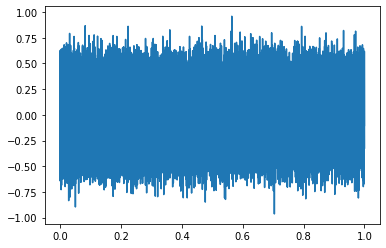

In [8]:
plt.plot(np.linspace(0,1,2 * fs), static)
plt.show()

All the work below here in this section is to compare this test noise to the wwv characterization noise.

In [9]:
wwv_characterization = pd.read_csv('test.csv',header=None).squeeze('columns').to_numpy()

In [10]:
len(wwv_characterization)

2016000

In [11]:
len(wwv_characterization)/fs

42.0

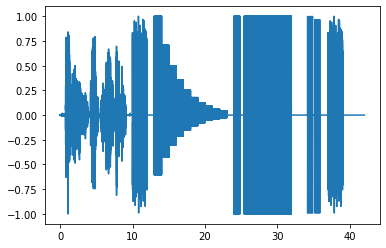

In [12]:
plt.plot(np.linspace(0,42, 42*fs), wwv_characterization)

In [13]:
wwv_noise = wwv_characterization[10 * fs:(10+2) * fs]

In [14]:
len(wwv_noise)

96000

In [15]:
len(wwv_noise)/fs

2.0

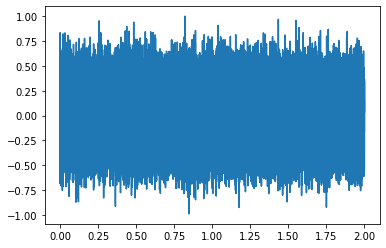

In [16]:
plt.plot(np.linspace(0,2,2*fs), wwv_noise)

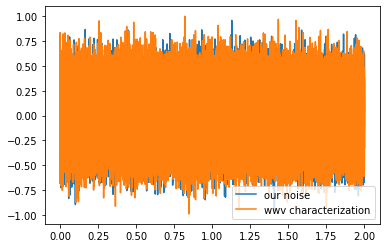

In [17]:
plt.plot(np.linspace(0,2,2*fs), static, label="our noise")
plt.plot(np.linspace(0,2,2*fs), wwv_noise, label="wwv characterization")
plt.legend()
plt.show()

## 2) Generate Morse signal from user's callsign. 
This signal is at 20 WPM. All callsigns must fit in the same time block... and should be received by RBN.

In [18]:
msg = 'TEST de ' + call +  "  " + maidenhead
# msg = msg * 3
print(msg)

TEST de KD8RV  EN82mj


Let's convert the signal to an on-off signal:

In [19]:
msg_cw = mtalk.encode(msg, encoding_type='binary')
msg_cw = np.array(list(msg_cw))
#msg_cw = pd.DataFrame(msg_cw)

In [20]:
msg_cw.dtype

dtype('<U1')

In [21]:
len(msg_cw)

187

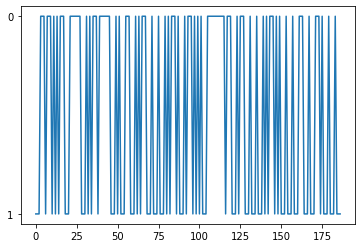

In [22]:
plt.plot(msg_cw)
plt.show()

We have to make sure this fits into a standard time frame, so let's prallocate an array of desired length, convert it to a list, and then add it in:

In [23]:
from fractions import Fraction

In [24]:
Fraction(1,2)

Fraction(1, 2)

In [25]:
def length_of_dit(wpm):
    """length of a dit in seconds given a words per minute"""
    return Fraction(1200, wpm)/1000 # seconds

In [26]:
assert float(length_of_dit(12)) == 0.1

In [27]:
length_of_dit(wpm)

Fraction(3, 50)

In [28]:
# length of cw message, seconds
cw_length = len(msg_cw) * length_of_dit(wpm)
cw_length

Fraction(561, 50)

In [29]:
float(cw_length)

11.22

In [30]:
# length of cw message, samples
cw_n_samples = cw_length * fs
cw_n_samples

Fraction(538560, 1)

In [31]:
assert _.denominator == 1

Generate a sinuisoidal carrier that we will multiply by the binary sequence.

In [32]:
t = np.linspace(1, float(cw_length), int(cw_n_samples))
f = 800
cw_carrier = np.cos(2 * np.pi * f * t)
cw_carrier

array([1.        , 0.99545414, 0.98185791, ..., 0.98185791, 0.99545414,
       1.        ])

In [33]:
assert len(cw_carrier) == int(cw_n_samples)

In [34]:
# samples in single dit
samples_on_dit = length_of_dit(wpm) * fs
samples_on_dit

Fraction(2880, 1)

In [35]:
assert samples_on_dit.denominator == 1

In [36]:
cw_mask = np.repeat(msg_cw, float(samples_on_dit))
cw_mask

array(['1', '1', '1', ..., '1', '1', '1'], dtype='<U1')

In [37]:
len(cw_mask)

538560

In [38]:
assert len(cw_mask) == cw_n_samples

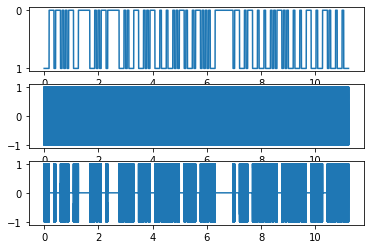

In [39]:
fig, axs = plt.subplots(3,1)
t = np.linspace(0, cw_length, int(cw_n_samples))
axs[0].plot(t, cw_mask)
axs[1].plot(t, cw_carrier)
axs[2].plot(t, cw_signal := cw_mask.astype(np.bool_) * cw_carrier)
plt.show()

In [40]:
from IPython.display import Audio

In [41]:
Audio(cw_signal, rate=fs)

## 3) Concatenate CW and radar chirps

Now we add in the lightsaber noises. Er, chirps. 

Our first version used chirps from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7659302.svg)](https://doi.org/10.5281/zenodo.7659302).
This version uses updated chirps from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10822389.svg)](https://doi.org/10.5281/zenodo.10822389). 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7659301.svg)](https://doi.org/10.5281/zenodo.7659301) will always point to the most recent version. 

In [42]:
#data = pd.read_csv('https://zenodo.org/record/10822389/files/seqp-test.csv?download=1').squeeze('columns')
#chirps = data.to_numpy()#.transpose()
sampRate, chirps = scipy.io.wavfile.read('SEQP Test Signal_v5_Science-payload_SHORT.wav')
chirps

C:\Users\tmcma\AppData\Local\Temp\ipykernel_27788\4253677415.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampRate, chirps = scipy.io.wavfile.read('SEQP Test Signal_v5_Science-payload_SHORT.wav')


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
Audio(chirps, rate=fs)

Let's also add in the 1kHz sine wave burst. We have this in the Zenodo repo as well:

In [44]:
data = pd.read_csv('https://zenodo.org/record/10822389/files/scienceborder.csv?download=1').squeeze('columns')
border = data.to_numpy()#.transpose()
Audio(border, rate=fs)

In [45]:
print(static.shape)
print(cw_signal.shape)
print(chirps.shape)
print(border.shape)

(96000,)
(538560,)
(490987,)
(95999,)


In [46]:
chirps = np.concatenate((chirps, [0]))

In [47]:
chirps.shape

(490988,)

In [48]:
signal = np.concatenate((border, static, cw_signal, chirps, static, border))
signal

array([ 0.18298506,  0.27055719,  0.3535    , ..., -0.18298506,
       -0.09228202,  0.        ])

In [49]:
len(signal)

1413546

In [50]:
len(signal) / fs

29.448875

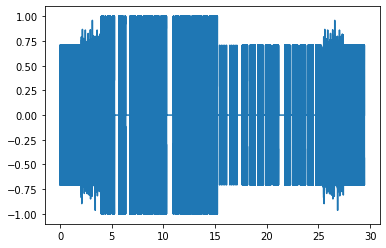

In [51]:
t = np.linspace(0,len(signal)/fs,len(signal))
plt.plot(t, signal)
plt.show()

In [52]:
Audio(signal, rate=fs)

## 4) Save File
Let's save the resulting .CSV and .WAV files with mnemonic filenames that include callsign and grid square.

In [53]:
filename = 'SEQP Test Signal_v2_' + call + ' ' + maidenhead
series = pd.Series(signal)
series.to_csv(filename+'.csv')

In [54]:
from scipy.io import wavfile

In [55]:
wavfile.write(filename+'.wav', fs, signal)